# Housing - exploratory data analysis (EDA)

NYC housing dataset b/w in 2012-13, seperated by boroughs

### The Unseen

- [] ..



In [178]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

pd.set_option('display.max_columns', 500)


In [183]:
# read all datasets w/ dates

raw_data = pd.read_csv('dataset/housing/rollingsales_manhattan.csv', parse_dates=['SALE DATE'], infer_datetime_format=True)
raw_data_bronx = pd.read_csv('dataset/housing/rollingsales_bronx.csv', parse_dates=['SALE DATE'], infer_datetime_format=True)
raw_data_brooklyn = pd.read_csv('dataset/housing/rollingsales_brooklyn.csv', parse_dates=['SALE DATE'], infer_datetime_format=True)
raw_data_queens = pd.read_csv('dataset/housing/rollingsales_queens.csv', parse_dates=['SALE DATE'], infer_datetime_format=True)
raw_data_statenisland = pd.read_csv('dataset/housing/rollingsales_statenisland.csv', parse_dates=['SALE DATE'],  infer_datetime_format=True)

# conembine all into 1
raw_data = raw_data.append([raw_data_bronx, raw_data_brooklyn, raw_data_queens, raw_data_statenisland], 
                           ignore_index=True)

# change column names
raw_data.columns = ['borough', 'neighborhood', 'building_class_category',
                    'tax_class_at_present', 'block', 'lot', 'easement',
                    'building_class_at_present', 'address', 'apartment_number',
                    'zipcode', 'residential_units', 'commercial_units', 'total_units',
                    'land_square_feet', 'gross_square_feet', 'year_built',
                    'tax_class_at_sale', 'building_class_at_sale',
                    'sale_price', 'sale_date']

# map and extract some of them
raw_data['borough_name'] = raw_data['borough'].map({1:'Manhattan', 3:'Brooklyn', 
                                                    2:'Bronx', 4:'Queens', 
                                                    5:'Staten Island'})   

raw_data['building_class'] = raw_data.building_class_category.str.split(n=1, expand=True)[0]
raw_data['building_class_name'] = raw_data.building_class_category.str.split(n=1, expand=True)[1]

# change column names' order
raw_data = raw_data[['borough', 'borough_name' , 'neighborhood', 'building_class_category', 
                     'building_class', 'building_class_name',
                     'tax_class_at_present', 'tax_class_at_sale', 'block', 'lot', 'easement',
                     'building_class_at_present', 'building_class_at_sale', 'address', 'apartment_number',
                     'zipcode', 'residential_units', 'commercial_units', 'total_units',
                     'land_square_feet', 'gross_square_feet', 'year_built',
                     'sale_date', 'sale_price']]


# possible deletion columns: 
#   1- borough, building_class_category .. (extracted into diff. columns)
#   2- block, lot (nonsense)
#   3- easement (%100 empty), apartment_number (%74 empty)

# domain knowledge 
#  1- building_class_at_present: may be mapped into 3 groups to use later ?
#  2- building_class_at_present vs building_class_at_sale change has any meaning?
#  3- tax_class_at_present vs tax_class_at_slae has any meaning?
#  4- 10019 zipcode is %7 of houses, and 70K houses are located in of 100 zipcodes


raw_data.head()

,borough,borough_name,neighborhood,building_class_category,building_class,building_class_name,tax_class_at_present,tax_class_at_sale,block,lot,easement,building_class_at_present,building_class_at_sale,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
0,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,13,CONDOS - ELEVATOR APARTMENTS,,2,738,1306,,,R4,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2013-05-20,"$2,214,693"
1,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,13,CONDOS - ELEVATOR APARTMENTS,,2,738,1307,,,R4,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2013-05-16,"$1,654,656"
2,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,13,CONDOS - ELEVATOR APARTMENTS,,2,738,1308,,,R4,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2013-05-23,"$1,069,162"
3,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,13,CONDOS - ELEVATOR APARTMENTS,,2,738,1309,,,R4,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2013-05-15,"$1,374,637"
4,1,Manhattan,,13 CONDOS - ELEVATOR APARTMENTS,13,CONDOS - ELEVATOR APARTMENTS,,2,738,1310,,,R4,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2013-05-13,"$1,649,565"


#### discover fields and values

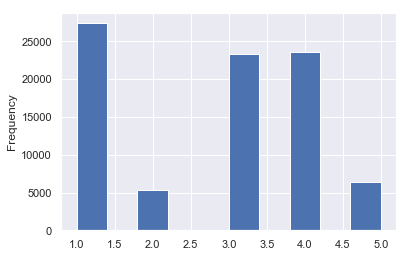

In [81]:
raw_data.borough.plot.hist()

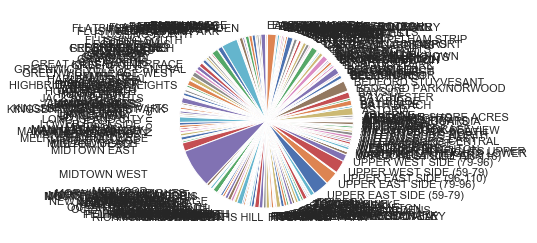

In [82]:
raw_data.groupby(raw_data.neighborhood).size().plot(kind='pie')

In [39]:
raw_data.land_square_feet.tail()

for col in ('land_square_feet', 'transaction_count'):
    data[col] = data[col].str.replace(r',', '').astype(int)

85970      2,590
85971      2,255
85972      4,000
85973     21,663
85974    489,656
Name: land_square_feet, dtype: object

In [45]:
raw_data.dtypes

borough                               int64
borough_name                         object
neighborhood                         object
building_class_category              object
tax_class_at_present                 object
tax_class_at_sale                    object
block                                 int64
lot                                   int64
easement                             object
building_class_at_present            object
building_class_at_sale               object
address                              object
apartment_number                     object
zipcode                               int64
residential_units                    object
commercial_units                     object
total_units                          object
land_square_feet                     object
gross_square_feet                    object
year_built                            int64
sale_date                    datetime64[ns]
sale_price                           object
dtype: object

In [173]:
raw_data.groupby('building_class_category').size().head(10)

# we shold split this column into 2 pieces

building_class_category
                                                 4204
01  ONE FAMILY HOMES                            14846
02  TWO FAMILY HOMES                            13678
03  THREE FAMILY HOMES                           4135
04  TAX CLASS 1 CONDOS                           1251
05  TAX CLASS 1 VACANT LAND                      1230
06  TAX CLASS 1 - OTHER                           180
07  RENTALS - WALKUP APARTMENTS                  3989
08  RENTALS - ELEVATOR APARTMENTS                 581
09  COOPS - WALKUP APARTMENTS                    2600
dtype: int64

(building_class_name
 ASYLUMS AND HOMES                              13
 COMMERCIAL CONDOS                            1682
 COMMERCIAL GARAGES                            888
 COMMERCIAL VACANT LAND                        464
 CONDO-RENTALS                                  34
 CONDOPS                                      1415
 CONDOS - 2-10 UNIT RESIDENTIAL               1123
 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT        85
 CONDOS - ELEVATOR APARTMENTS                13313
 CONDOS - WALKUP APARTMENTS                    929
 COOPS - ELEVATOR APARTMENTS                 13771
 COOPS - WALKUP APARTMENTS                    2600
 EDUCATIONAL FACILITIES                         63
 FACTORIES                                     346
 HOSPITAL AND HEALTH FACILITIES                 38
 INDOOR PUBLIC AND CULTURAL FACILITIES          28
 LOFT BUILDINGS                                144
 LUXURY HOTELS                                1647
 OFFICE BUILDINGS                              432
 ONE FAMIL

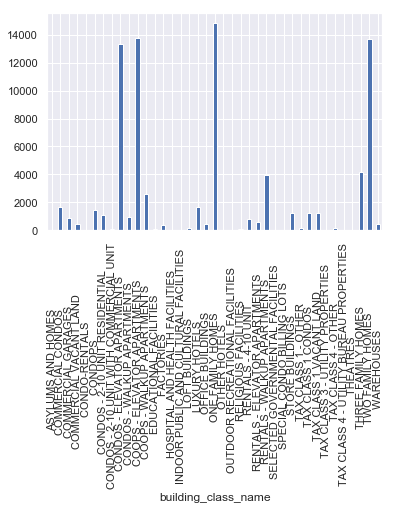

In [251]:
df = raw_data

df['building_class'] = df.building_class_category.str.split(n=1, expand=True)[0]
df['building_class_name'] = df.building_class_category.str.split(n=1, expand=True)[1]

# df['building_class'] = x[0]
# df['building_class_category'] = x[1]

k = df.groupby('building_class_name').size()
k, k.plot(kind='bar')

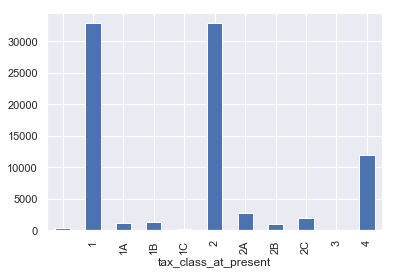

In [196]:

raw_data.groupby('tax_class_at_present').size().plot(kind='bar')


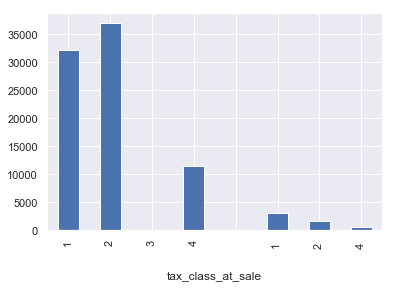

In [197]:
raw_data.groupby('tax_class_at_sale').size().plot(kind='bar')

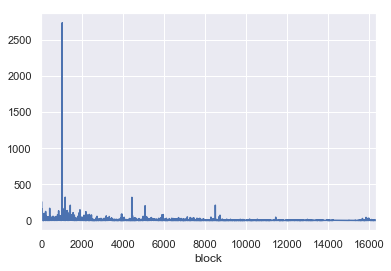

In [199]:
raw_data.groupby('block').size().plot()

# it reads as numerical, but infact categorical
# can be deleted

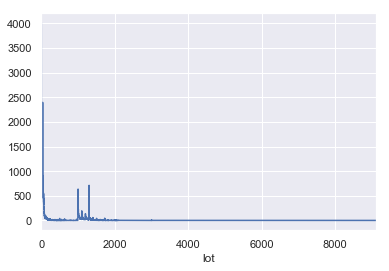

In [200]:
raw_data.groupby('lot').size().plot()
# it reads as numerical, but infact categorical
# can be deleted

In [203]:
raw_data.groupby('easement').size()

# can be deleted

easement
     85973
E        2
dtype: int64

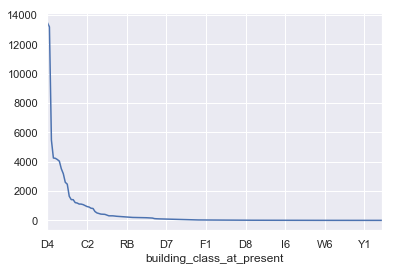

In [218]:
raw_data.groupby('building_class_at_present').size().sort_values(ascending=False).plot()

# some has +100 items? need domain knowledge to extract a meaningful sense
# building_class_at_present: may be mapped into 3 groups to use later ?

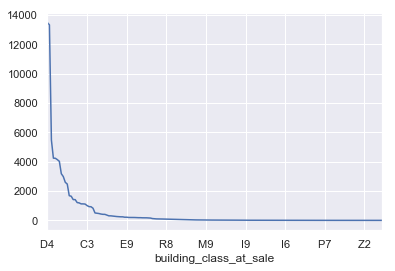

In [219]:
raw_data.groupby('building_class_at_sale').size().sort_values(ascending=False).plot()

In [221]:
raw_data.groupby('apartment_number').size().sort_values(ascending=False)

apartment_number
                63830
TIMES             599
4                 273
3B                249
3A                244
2                 235
3                 233
6                 228
2A                222
4A                219
4B                206
1                 205
2B                195
1A                185
5B                170
3C                170
4C                160
1B                148
5A                147
6A                131
5C                130
6B                127
2C                120
4D                116
5                 115
2D                109
3D                109
3E                108
8                 104
6C                 97
                ...  
P39                 1
P3A                 1
4JJ                 1
4H2                 1
4G3                 1
4FL                 1
5 3L                1
5 4B                1
5 4C                1
5 4J                1
P25D                1
5-2D                1
5 SO                1
5 8E           

In [235]:
raw_data.groupby('zipcode').size().sort_values(ascending=False).head(100)#.plot(kind='pie')

# 10019 zipcode is %7 of houses
# 70K houses in 100 zipcodes

zipcode
10019    6193
10023    1514
11207    1357
11201    1314
10011    1261
11375    1200
10314    1164
10016    1147
10022    1119
11215    1106
10025    1076
10021    1072
10128    1042
10024    1009
11354     999
10065     989
11221     960
11235     947
10312     928
10003     873
11355     864
11234     852
11238     812
10028     810
10306     795
10013     791
11229     775
11211     756
11385     755
11223     721
         ... 
11414     464
10463     463
11379     462
10012     457
11213     457
11435     454
11365     429
10308     427
11222     425
11378     419
11203     415
10462     413
11412     410
11360     404
11226     404
11413     400
11210     400
11106     395
11432     394
11420     393
11361     387
11433     382
11356     375
10465     374
10461     373
11362     368
10001     363
11418     361
10027     354
10466     351
Length: 100, dtype: int64

In [270]:
k = raw_data[['building_class_name', 'residential_units']]
# k['len'] = k.building_class_name.str.len()
# k = k[k.building_class_name == 'TWO FAMILY HOMES                        ']


#CONDOS - ELEVATOR APARTMENTS 
k.groupby([ 'building_class_name', 'residential_units']).size().sort_values(ascending=False).unstack('building_class_name')#.plot(kind='pie')

building_class_name,ASYLUMS AND HOMES,COMMERCIAL CONDOS,COMMERCIAL GARAGES,COMMERCIAL VACANT LAND,CONDO-RENTALS,CONDOPS,CONDOS - 2-10 UNIT RESIDENTIAL,CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,CONDOS - ELEVATOR APARTMENTS,CONDOS - WALKUP APARTMENTS,COOPS - ELEVATOR APARTMENTS,COOPS - WALKUP APARTMENTS,EDUCATIONAL FACILITIES,FACTORIES,HOSPITAL AND HEALTH FACILITIES,INDOOR PUBLIC AND CULTURAL FACILITIES,LOFT BUILDINGS,LUXURY HOTELS,OFFICE BUILDINGS,ONE FAMILY HOMES,OTHER HOTELS,OUTDOOR RECREATIONAL FACILITIES,RELIGIOUS FACILITIES,RENTALS - 4-10 UNIT,RENTALS - ELEVATOR APARTMENTS,RENTALS - WALKUP APARTMENTS,SELECTED GOVERNMENTAL FACILITIES,SPECIAL CONDO BILLING LOTS,STORE BUILDINGS,TAX CLASS 1 - OTHER,TAX CLASS 1 CONDOS,TAX CLASS 1 VACANT LAND,TAX CLASS 3 - UTILITY PROPERTIES,TAX CLASS 4 - OTHER,TAX CLASS 4 - UTILITY BUREAU PROPERTIES,THEATRES,THREE FAMILY HOMES,TWO FAMILY HOMES,WAREHOUSES
residential_units,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.0,488.0,372.0,199.0,NaN,92.0,50.0,28.0,36.0,NaN,2164.0,685.0,29.0,166.0,9.0,11.0,10.0,2.0,144.0,1.0,9.0,7.0,36.0,NaN,NaN,NaN,4.0,NaN,443.0,75.0,11.0,677.0,3.0,112.0,NaN,3.0,1.0,1.0,207.0
1,2.0,NaN,2.0,NaN,NaN,1.0,625.0,NaN,2834.0,532.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,21.0,6380.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,1.0,784.0,8.0,NaN,2.0,NaN,NaN,NaN,1.0,2.0
2,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,3.0,2.0,NaN,NaN,1.0,41.0,NaN,2.0,NaN,NaN,28.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,2.0,7274.0,3.0
3,1.0,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,117.0,NaN,1.0,NaN,NaN,7.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2306.0,3.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.0,1.0,661.0,NaN,NaN,8.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,67.0,1.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,479.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,58.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
type(3400000)

int

In [72]:
raw_data.describe(include='all')

,borough,borough_name,neighborhood,building_class_category,tax_class_at_present,tax_class_at_sale,block,lot,easement,building_class_at_present,building_class_at_sale,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
count,85975.000000,85975,85975,85975,85975,85975.0,85975.000000,85975.000000,85975,85975,85975,85975,85975,85975.000000,85975,85975.0,85975,85975,85975,85975.000000,85975,85975
unique,NaN,5,257,40,11,8.0,NaN,NaN,2,170,170,63419,4492,NaN,261,81.0,273,6245,6539,NaN,386,10222
top,NaN,Manhattan,MIDTOWN WEST,01 ONE FAMILY HOMES,2,2.0,NaN,NaN,,D4,D4,870 7 AVENUE,,NaN,0,0.0,1,0,0,NaN,2012-09-27 00:00:00,$0
freq,NaN,27395,6264,14846,32899,36960.0,NaN,NaN,85973,13461,13461,2087,63830,NaN,24544,55360.0,25991,40340,42780,NaN,988,26959
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-26 00:00:00,NaN
mean,2.723606,NaN,NaN,NaN,NaN,NaN,3661.041721,405.420541,NaN,NaN,NaN,NaN,NaN,10758.035254,NaN,NaN,NaN,NaN,NaN,1681.403303,NaN,NaN
std,1.352580,NaN,NaN,NaN,NaN,NaN,3404.028873,652.166743,NaN,NaN,NaN,NaN,NaN,662.101399,NaN,NaN,NaN,NaN,NaN,670.796500,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,1052.000000,23.000000,NaN,NaN,NaN,NaN,NaN,10028.000000,NaN,NaN,NaN,NaN,NaN,1910.000000,NaN,NaN
